a. Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

b. Uploading the Dataset

In [8]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df = df.drop(columns=['Time'])

X = df.drop(columns=['Class'])
Y = df['Class'] 

In [10]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [12]:
Y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [14]:
#normalise 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

d. Splitting the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)


e. AutoEncoder Model

In [17]:
#encoder
input_dim = X_train.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim, ))
encoded= Dense(encoding_dim, activation='relu')(input_layer)

#decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

#autoencoder
autoencoder  =  Model(input_layer,decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

f. train the model

In [18]:
train = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3228 - loss: 0.9534 - val_accuracy: 0.6995 - val_loss: 0.7147
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7192 - loss: 0.7161 - val_accuracy: 0.7750 - val_loss: 0.6859
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7888 - loss: 0.6783 - val_accuracy: 0.8351 - val_loss: 0.6748
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8509 - loss: 0.6807 - val_accuracy: 0.8920 - val_loss: 0.6681
Epoch 5/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8958 - loss: 0.6817 - val_accuracy: 0.9197 - val_loss: 0.6652
Epoch 6/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9215 - loss: 0.6646 - val_accuracy: 0.9308 - val_loss: 0.6637
Epoch 7/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9325 - loss: 0.6765 - val_accuracy: 0.9373 - val_loss: 0.6630
Epoch 8/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9381 - loss: 0.6588 - val_accuracy: 0.

g. Evaluate the Model

In [19]:
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - reconstructed, 2), axis=1)
print(reconstruction_error)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step
[64.20857599  0.74690705  0.2155702  ...  0.70204959  0.12195886
  2.42145421]


In [20]:
#setting the threshold
threshold = np.percentile(reconstruction_error, 95)

anomolies = reconstruction_error > threshold

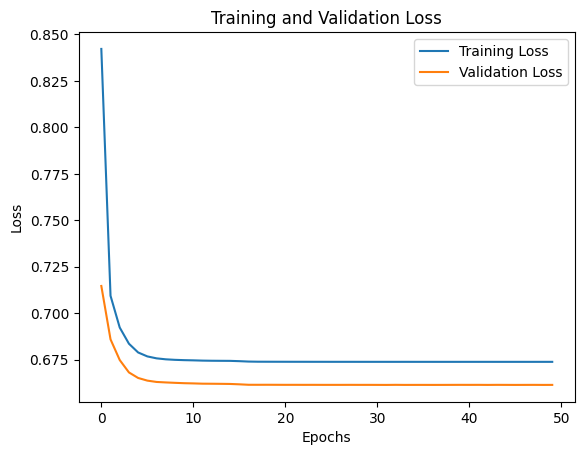

In [22]:
# Step 10: Visualize the training loss
plt.plot(train.history['loss'], label='Training Loss')
plt.plot(train.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
print(f"Anomalies detected: {np.sum(anomolies)}")
print(f"Total test instances: {len(X_test)}")
print(f"Anomaly Detection Rate: {np.sum(anomolies) / len(X_test):.2f}")

Anomalies detected: 2849
Total test instances: 56962
Anomaly Detection Rate: 0.05


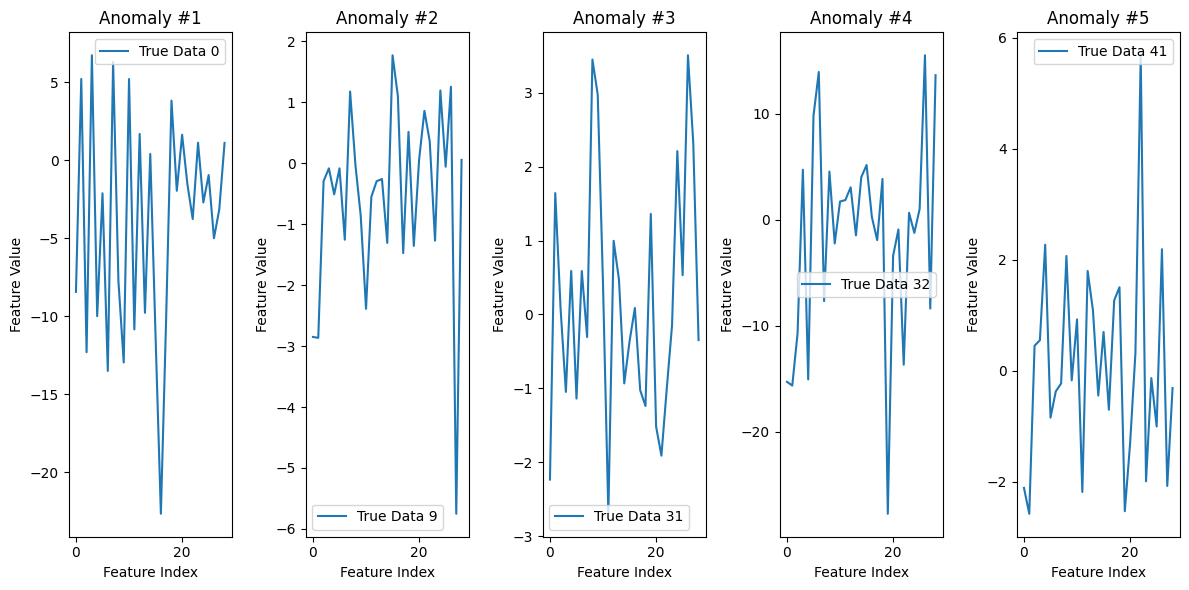

In [27]:
num_anomalies = 5
anomaly_indices = np.where(anomolies)[0][:num_anomalies]

plt.figure(figsize=(12, 6))

for i, idx in enumerate(anomaly_indices):
    plt.subplot(1, num_anomalies, i+1)
    plt.plot(X_test[idx], label=f"True Data {idx}")
    plt.title(f"Anomaly #{i+1}")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.legend()

plt.tight_layout()
plt.show()


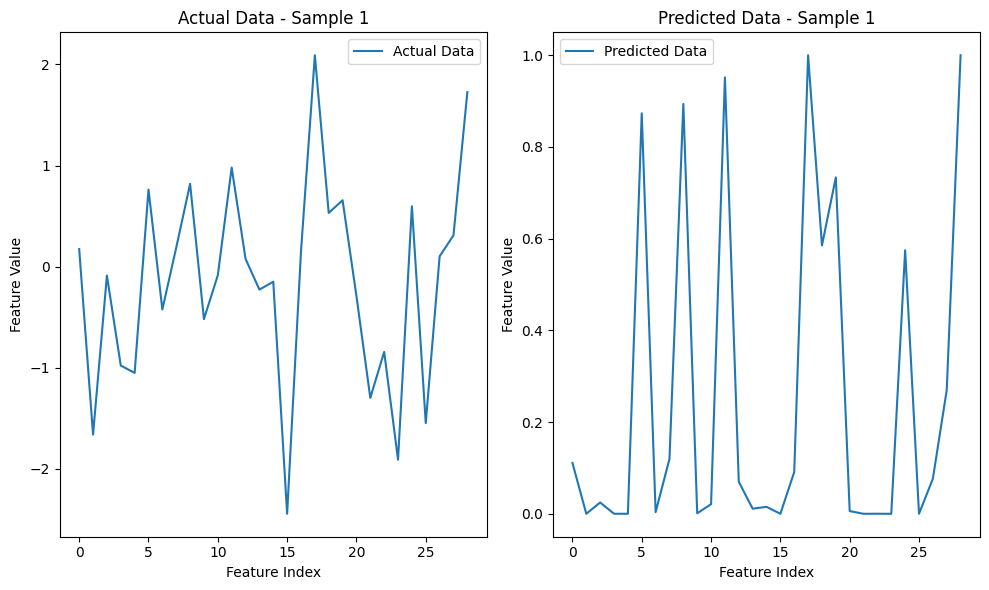

In [31]:
sample_idx = 1
# Visualize the actual data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(X_test[sample_idx], label="Actual Data")
plt.title(f"Actual Data - Sample {sample_idx}")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()

# Visualize the predicted data (from the Autoencoder)
plt.subplot(1, 2, 2)
plt.plot(reconstructed[sample_idx], label="Predicted Data")
plt.title(f"Predicted Data - Sample {sample_idx}")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
#daata